In [47]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
# print(IN_COLAB)

if IN_COLAB:
    !git clone https://github.com/ssuai/ISLP.git
    !git clone https://github.com/puroong/2025-SSUML
    #!pip install ISLP # This takes too much time

fatal: destination path 'ISLP' already exists and is not an empty directory.
Cloning into '2025-SSUML'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 7), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 70.90 KiB | 1.48 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [105]:
from ISLP.utils import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
import statsmodels.api as sm
from ISLP.models import sklearn_sm
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [49]:
import pandas as pd
from datetime import datetime

# helper function for reading datatset
def read_data(file_path, date_format = '%Y-%m-%d'):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format) # convert it to datatime

    return df

df_train = read_data('2025-SSUML/data/kospi_train.csv')
df_test = read_data('2025-SSUML/data/kospi_test.csv')

len(df_train), len(df_test)

(986, 244)

In [117]:
import matplotlib.pyplot as plt
import itertools

def column_combination():
  significant_columns = ['Open', 'Low', 'High', 'Close', 'Volume']

  for r in range(1, len(significant_columns)+1):
      l = itertools.combinations(significant_columns, r)
      for i in l:
          yield list(i)

model_by_terms = {}

X_test = None

for terms in column_combination():
  X_test = MS(terms).fit_transform(df_test)[:-1].reset_index(drop=True)
  y_test = df_test['Close'][1:].reset_index(drop=True)


  X = MS(terms).fit_transform(df_train)[:-1].reset_index(drop=True)
  y = df_train['Close'][1:].reset_index(drop=True)

  model = sm.OLS(y, X)
  result = model.fit()

  print('#' * 100)
  print(terms)
  print(summarize(result))

  cv = KFold(n_splits=100, shuffle=True, random_state=0)
  m_cv = sklearn_sm(sm.OLS,
                      MS(terms))

  cv_results = cross_validate(m_cv,
                              X,
                              y,
                              cv=cv)
  cv_err = np.mean(cv_results['test_score'])


  y_pred_test = result.predict(X_test)
  y_pred_train = result.predict(X)
  mse = mean_squared_error(y_test, y_pred_test)

  print(f'cv_err: {cv_err}')
  print(f'mse: {mse}')

  plt.plot(df_train['Date'], df_train['Close'])
  plt.plot(df_train['Date'][1:], y_pred_train, color='red')
  plt.show()

  plt.plot(df_test['Date'], df_test['Close'])
  plt.plot(df_test['Date'][1:], y_pred_test, color='yellow')
  plt.show()

  model_by_terms[str(terms)] = result

Output hidden; open in https://colab.research.google.com to view.

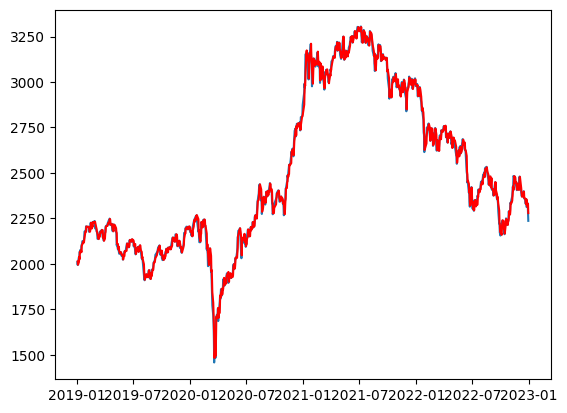

In [113]:
import matplotlib.pyplot as plt

terms = ['Open', 'Low', 'High', 'Close', 'Volume']
result = model_by_terms[str(terms)]
y_pred_test = result.predict(X_test)
y_pred_train = result.predict(X)

plt.plot(df_train['Date'], df_train['Close'])
plt.plot(df_train['Date'][1:], y_pred_train, color='red')


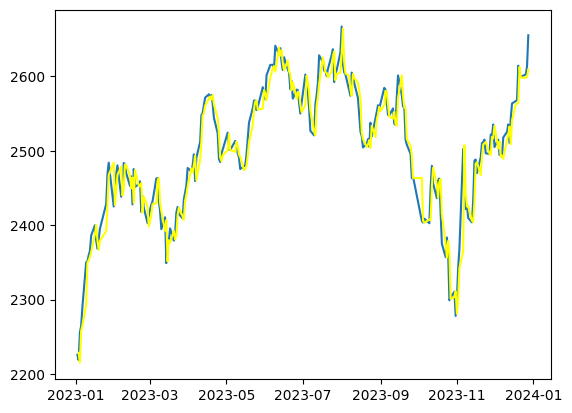

In [114]:
plt.plot(df_test['Date'], df_test['Close'])
plt.plot(df_test['Date'][1:], y_pred_test, color='yellow')


In [102]:
# Q2

df_currency_train = read_data('2025-SSUML/data/currency_train.csv', date_format='%m/%d/%Y')
df_currency_test = read_data('2025-SSUML/data/currency_test.csv', date_format='%m/%d/%Y')

del df_currency_train['Vol.']
del df_currency_test['Vol.']
del df_currency_train['Change %']
del df_currency_test['Change %']

df_currency_train = df_currency_train.apply(lambda col: col.str.replace(',', '', regex=False).astype(float) if col.dtypes == 'object' else col)
df_currency_test = df_currency_test.apply(lambda col: col.str.replace(',', '', regex=False).astype(float) if col.dtypes == 'object' else col)

df_currency_train = df_currency_train.rename(
    columns={
        "Price": "currency_price",
        "Open": "currency_open",
        "High": "currency_high",
        "Low": "currency_low",
        "Close": "currency_close"
    }
)

df_currency_test = df_currency_test.rename(
    columns={
        "Price": "currency_price",
        "Open": "currency_open",
        "High": "currency_high",
        "Low": "currency_low",
        "Close": "currency_close"
    }
)

len(df_currency_train), len(df_currency_test)

(1042, 260)

In [103]:
df_merged_train = pd.merge(df_train, df_currency_train, on='Date', how='outer')
df_merged_train = df_merged_train.dropna()

df_merged_test = pd.merge(df_test, df_currency_test, on='Date', how='outer')
df_merged_test = df_merged_test.dropna()

df_merged_train

,Date,Open,Low,High,Close,Volume,currency_price,currency_open,currency_high,currency_low
0,2019-01-02,2050.550049,2004.270020,2053.449951,2010.000000,326400.0,1119.12,1114.00,1122.96,1113.70
1,2019-01-03,2011.810059,1991.650024,2014.719971,1993.699951,428000.0,1124.89,1120.12,1130.63,1119.19
2,2019-01-04,1992.400024,1984.530029,2011.560059,2010.250000,409000.0,1115.85,1125.89,1128.06,1115.44
3,2019-01-07,2034.239990,2030.900024,2048.060059,2037.099976,440200.0,1116.66,1116.40,1121.17,1114.66
4,2019-01-08,2038.680054,2023.589966,2042.699951,2025.270020,397800.0,1121.83,1117.66,1127.00,1116.65
...,...,...,...,...,...,...,...,...,...,...
1037,2022-12-23,2325.860107,2311.899902,2333.080078,2313.689941,367000.0,1279.55,1291.94,1292.57,1278.05
1038,2022-12-26,2312.540039,2304.199951,2321.919922,2317.139893,427600.0,1273.91,1279.80,1282.20,1273.89
1039,2022-12-27,2327.520020,2321.479980,2335.989990,2332.790039,448300.0,1271.79,1274.91,1275.63,1264.85
1040,2022-12-28,2296.449951,2276.899902,2296.449951,2280.449951,405700.0,1274.37,1272.25,1276.66,1265.57


In [120]:
import matplotlib.pyplot as plt
import itertools

def column_combination():
  significant_columns = ['Open', 'Low', 'High', 'Close', 'Volume'] + list(df_currency_train.columns.drop('Date'))

  for r in range(1, len(significant_columns)+1):
      l = itertools.combinations(significant_columns, r)
      for i in l:
          yield list(i)

model_by_terms = {}

X_test = None

for terms in column_combination():
  X_test = MS(terms).fit_transform(df_merged_test)[:-1].reset_index(drop=True)
  y_test = df_merged_test['Close'][1:].reset_index(drop=True)


  X = MS(terms).fit_transform(df_merged_train)[:-1].reset_index(drop=True)
  y = df_merged_train['Close'][1:].reset_index(drop=True)

  model = sm.OLS(y, X)
  result = model.fit()

  print('#' * 100)
  print(terms)
  print(summarize(result))

  cv = KFold(n_splits=100, shuffle=True, random_state=0)
  m_cv = sklearn_sm(sm.OLS,
                      MS(terms))

  cv_results = cross_validate(m_cv,
                              X,
                              y,
                              cv=cv)
  cv_err = np.mean(cv_results['test_score'])


  y_pred_test = result.predict(X_test)
  y_pred_train = result.predict(X)
  mse = mean_squared_error(y_test, y_pred_test)

  print(f'cv_err: {cv_err}')
  print(f'mse: {mse}')

  plt.plot(df_train['Date'], df_train['Close'])
  plt.plot(df_train['Date'][1:], y_pred_train, color='red')
  plt.show()

  plt.plot(df_test['Date'], df_test['Close'])
  plt.plot(df_test['Date'][1:], y_pred_test, color='yellow')
  plt.show()

  model_by_terms[str(terms)] = result

Output hidden; open in https://colab.research.google.com to view.